#Exploring Sleep Debt & Health Markers

Literature shows that the type of good health I seek, that of a physically fit athlete, is best examined with the following rubric.

1. According to Wikipedia: "Sleep debt or sleep deficit is the cumulative effect of not getting enough sleep. A large sleep debt may lead to mental or physical fatigue. There are two kinds of sleep debt: the results of partial sleep deprivation and total sleep deprivation." My biggest concern is that sleep deprivation is an indicator of brain degeneration in the elderly. My goal is to work on trending my sleep debt down through sleep hygiene techniques.
2. Resting heart rate (RHR) can be the result of a high level of fitness, meditative breathing, and sleep. There are other reasons, such as disease, diet, family history, and medication, which can result in a low resting heart rate. For my health purposes, I expect to see that when I am healthy and doing self-care (such as meditation, high cardio workouts, sleep hygiene, etc.), my resting heart rate will be relatively steady. And if trends present themselves, the RHR will be trending down.
3. Maximum heart rate (MHR) is the number of beats the heart makes during strenuous exercise. While a high heart rate can be a sign of a medical issue, it is also an indicator of good health. If during use, the heart beats more often as a result of the exercise, it can be a sign of proper conditioning. There is always a countervailing pressure that as the heart becomes more conditioned, it beats slower. My goal is to grow my MHR or at least stay on an even trendline.
4. Heart rate variability (HRV) is the interplay between the sympathetic and parasympathetic branches of the autonomic nervous system. During relaxation, the HRV goes up, and during stress and exercise, the HRV goes down. HRV plays a role as a good indicator of recovery from illness, anxiety, and training. My goal is to drive my average HRV score up over time.
5. Calories burned beyond primary body function are an indication of a strengthened heart which lowers the RHR, encourages the MHR upward, and promotes healthy sleep patterns.
6. REM sleep is a phase of sleep that lasts approximately 25% of any sleep period. It is commonly associated with the processing of learning, memory, and emotional state. Excessive strain, alcohol, and medical issues can suppress REM sleep. While there are exceptions due to circumstances of medicines, drink, and illness, a healthy sleep pattern should involve rough parity between time spent in REM and deep sleep.
7. Deep sleep, or slow-wave sleep, is a phase of sleep most commonly associated with the body recovering from physical exertion during the previous awake period. Excessive strain, alcohol, and medical issues can suppress deep sleep (also called delta wave sleep). While there are exceptions due to circumstances of medicines, alcohol, and illness, a healthy sleep pattern should involve rough parity between time spent in REM and deep sleep.

##Personal Fitness Markers

This study uses personal fitness markers I gathered over the period between February 7, 2018, and February 7, 2020. These two years constitute a big transition in my life between being able to devote a reasonable amount of time and effort to my physical fitness, through some bad injuries, and into a change of life direction into less physical exercise due to injury. These markers were gathered daily through a fitness tracker from Whoop and other methods.  

In [0]:
#import libraries and methods
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [0]:
%%capture
!pip install category_encoders
import category_encoders as ce

In [0]:
#set some options for the notebook

pd.options.display.max_rows = 50
pd.options.mode.chained_assignment = None

In [0]:
#Import the data from a live Google spreadsheet in CSV. This file is updated regularly.

df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTMIUP6_JIoxWSAFCe1h6Hz12r-41t6qHv5cCXIBmYJUK2KS188pKkZnkr4jJRpIcC3mRZV36z21oNv/pub?gid=0&single=true&output=csv')

In [0]:
#Adding a proper header to the file. Going to do some feature engineering, adding columns, 
#re-setting index.

header_list = ['Date','Weight','Fat','Sleep Debt','REM','Deep Sleep','Snore',
     'Meditate','Spanish','Push-ups','Pull-ups','Sit-ups','Coffee','Handstands',
     'Acro','Swing','Strain','Calories','AHR','MHR','HRV','RHR','Recovery',
     'Carbs','Journal','Spinal Mobility','Flexibility','Notes','DOW',
     'Weight_AVR','Fat_AVR','Sleep Debt_AVR','REM_AVR','Deep Sleep_AVR',
     'Strain_AVR','Calories_AVR','AHR_AVR','MHR_AVR','HRV_AVR','RHR_AVR',
     'Recovery_AVR','Weight_PASS','Fat_PASS','Sleep Debt_PASS','REM_PASS',
     'Deep Sleep_PASS','Strain_PASS','Calories_PASS','AHR_PASS','MHR_PASS',
     'HRV_PASS','RHR_PASS','Recovery_PASS']

df = df.reindex(columns = header_list)

In [0]:
#Setting date column to pandas datetime object and then engineering a day of the week feature.

df['Date'] = pd.to_datetime(df['Date'])

for i in range(len(df)):
    df['DOW'][i] = df['Date'][i].day_name()

In [0]:
#Lists of features to be used in analysis. These are subsets of header_list.

features = ['Weight','Fat','Sleep Debt','REM','Deep Sleep','Strain','Calories',
            'AHR','MHR','HRV','RHR','Recovery']

special_features = ['Sleep Debt','AHR','RHR']

#Note: Dropping DOW which was engineered directly above.
drops = ['Acro','Meditate','Snore','Coffee','Handstands','Spanish','Push-ups',
         'Pull-ups','Sit-ups','Swing','Carbs','Journal','Spinal Mobility',
         'Flexibility','Notes','DOW']

week_day = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [0]:
#Dropping columns which will not be used in this iteration of this analysis.

df = df.drop(labels=drops,axis=1)

In [0]:
#Interpolating columns for missing values. 

for each in features:
    df[each] = df[each].interpolate(method='linear')

In [0]:
#Engineering an average column for each feature.

for i in range(0,df.shape[0]-1):
    for j in range(len(features)):
        string = features[j] + '_AVR'
        df[string] = df.iloc[:,j+1].expanding(min_periods=7).mean()

In [0]:
#Using these averages to create a new feature which promotes the marker responses I seek.
#For instance I want my sleep debt to be rewarded for going below the average while I want 
#my MHR to be rewarded for rising. This column will be part of my predictive modeling.

for i in range(len(df)):
  for feat in features:
    score = feat + '_PASS'
    avr = feat + '_AVR'
    if feat not in special_features:
      if df[feat][i] >= df[avr][i]:
        df[score][i] = "Y"
      else:
        df[score][i] = "N"
    elif feat in special_features:
      if df[feat][i] <= df[avr][i]:
        df[score][i] = "Y"
      else:
        df[score][i] = "N"

##Visualizations of basic trends.

In [12]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df['REM_AVR'], name="REM",
                         line_color='dimgray'))

fig.add_trace(go.Scatter(x=df.Date, y=df['Deep Sleep_AVR'], name="Deep Sleep",
                         line_color='rosybrown'))

fig.add_trace(go.Scatter(x=df.Date, y=df['Sleep Debt_AVR'], name="Sleep Debt",
                         line_color='deepskyblue'))

fig.update_layout(title_text='Sleep Hygiene Progress February 2018 through February 2020',
                  xaxis_rangeslider_visible=True)
fig.show()

###Visualization of REM & Deep Sleep Flip Post Concussion

In [13]:
concuss = df[(df['Date'] <= '04/30/2019') & (df['Date'] >= '04/21/2019')]
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=concuss.Date, y=concuss['REM'], name="REM",
                         line_color='dimgray'))

fig.add_trace(go.Scatter(x=concuss.Date, y=concuss['Deep Sleep'], name="Deep Sleep",
                         line_color='rosybrown'))

fig.add_trace(go.Scatter(x=concuss.Date, y=concuss['Sleep Debt'], name="Sleep Debt",
                         line_color='deepskyblue'))

fig.update_layout(title_text='Visualization of REM & Deep Sleep Flip Post Concussion',
                  xaxis_rangeslider_visible=False)
fig.show()

##Predictive Modeling

###Random Forest Categorical Predictive Modeling

In [0]:
#Create train, validation, & test sets.

test = df[df['Date'] >= '11/29/2019']
train = df[(df['Date'] <= '07/24/2019') & (df['Date'] >= '02/13/2018')]
val = df[(df['Date'] <= '11/28/2019') & (df['Date'] >= '07/25/2019')]

In [15]:
test.shape, train.shape, val.shape

((69, 37), (527, 37), (127, 37))

Target & Features

In [0]:
target = 'Sleep Debt_PASS'
# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 25].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
#Begin setting up models

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [18]:
#Find baseline

y_train.value_counts(normalize=True)

Y    0.535104
N    0.464896
Name: Sleep Debt_PASS, dtype: float64

In [0]:
#Set up initial pipeline

pipeline = make_pipeline( 
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(max_features='sqrt',n_estimators=100,n_jobs=-1, random_state=42)
)

In [20]:
#Fit & score on validation set.
pipeline.fit(X_train, y_train)

print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.8110236220472441


In [0]:
#Prediction set for test score.

y_pred = pipeline.predict(X_test)

In [22]:
#Quick check on prediction array. Visually this is an error check as it should 
#not be either all 'Y' or all 'N'.

y_pred

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'Y'], dtype=object)

In [23]:
#Score on test set  
print('Test Accuracy:',pipeline.score(X_test,y_test))

Test Accuracy: 0.36231884057971014


###Begin Manual Encoding for Importances and Eli5


In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [25]:
X_train_encoded

,Weight,Fat,Sleep Debt,REM,Deep Sleep,Strain,Calories,AHR,MHR,HRV,RHR,Recovery,Weight_AVR,Fat_AVR,Sleep Debt_AVR,REM_AVR,Deep Sleep_AVR,Strain_AVR,Calories_AVR,AHR_AVR,MHR_AVR,HRV_AVR,RHR_AVR,Recovery_AVR,Weight_PASS_Y,Weight_PASS_N,Fat_PASS_Y,Fat_PASS_N,REM_PASS_Y,REM_PASS_N,Deep Sleep_PASS_Y,Deep Sleep_PASS_N,Strain_PASS_Y,Strain_PASS_N,Calories_PASS_Y,Calories_PASS_N,AHR_PASS_N,AHR_PASS_Y,MHR_PASS_N,MHR_PASS_Y,HRV_PASS_N,HRV_PASS_Y,RHR_PASS_N,RHR_PASS_Y,Recovery_PASS_N,Recovery_PASS_Y
6,151.800000,13.200000,80.000000,47.000000,78.000000,12.10,3321.000000,84.000000,155.000000,20.000000,69.000000,32.000000,151.142857,13.085714,85.714286,36.000000,77.000000,11.671429,3171.428571,79.571429,158.285714,21.571429,67.571429,38.142857,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
7,151.400000,13.200000,104.000000,81.000000,37.000000,8.80,2406.000000,77.000000,151.000000,22.000000,72.000000,39.000000,151.175000,13.100000,88.000000,41.625000,72.000000,11.312500,3075.750000,79.250000,157.375000,21.625000,68.125000,38.250000,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1
8,151.800000,13.200000,94.000000,35.000000,115.000000,10.70,2820.000000,79.000000,161.000000,20.000000,68.000000,35.000000,151.244444,13.111111,88.666667,40.888889,76.777778,11.244444,3047.333333,79.222222,157.777778,21.444444,68.111111,37.888889,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0
9,151.800000,13.200000,89.000000,43.000000,165.000000,14.60,4826.000000,87.000000,156.000000,26.000000,72.000000,64.000000,151.300000,13.120000,88.700000,41.100000,85.600000,11.580000,3225.200000,80.000000,157.600000,21.900000,68.500000,40.500000,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1
10,152.200000,13.400000,69.000000,58.000000,37.000000,13.10,3725.000000,91.000000,158.000000,40.000000,65.000000,93.000000,151.381818,13.145455,86.909091,42.636364,81.181818,11.718182,3270.636364,81.000000,157.636364,23.545455,68.181818,45.272727,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,155.956410,14.219231,89.434783,95.311111,74.911111,9.45,1991.788889,75.388889,161.477778,34.988889,64.522222,34.811111,150.937812,13.093304,82.675392,63.775698,61.966058,12.544423,3428.294623,80.164566,161.017034,30.589330,65.017937,46.146209,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0
529,155.974359,14.223077,89.717391,95.155556,74.955556,9.50,2008.644444,75.444444,161.488889,35.244444,64.511111,35.155556,150.947315,13.095435,82.688679,63.834906,61.990566,12.538679,3425.616038,80.155660,161.017925,30.598113,65.016981,46.125472,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0
530,155.992308,14.226923,90.000000,95.000000,75.000000,9.55,2025.500000,75.500000,161.500000,35.500000,64.500000,35.500000,150.956816,13.097566,82.702448,63.893597,62.015066,12.533051,3422.979284,80.146893,161.018832,30.607345,65.016008,46.105461,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0
531,156.010256,14.230769,90.282609,94.844444,75.044444,9.60,2042.355556,75.555556,161.511111,35.755556,64.488889,35.844444,150.966315,13.099696,82.716697,63.951775,62.039557,12.527538,3420.384127,80.138262,161.019758,30.617022,65.015017,46.086174,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0


In [0]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [27]:
X_train_imputed

array([[151.8       ,  13.2       ,  80.        , ...,   0.        ,
          1.        ,   0.        ],
       [151.4       ,  13.2       , 104.        , ...,   0.        ,
          0.        ,   1.        ],
       [151.8       ,  13.2       ,  94.        , ...,   1.        ,
          1.        ,   0.        ],
       ...,
       [155.99230769,  14.22692308,  90.        , ...,   1.        ,
          1.        ,   0.        ],
       [156.01025641,  14.23076923,  90.2826087 , ...,   1.        ,
          1.        ,   0.        ],
       [156.02820513,  14.23461538,  90.56521739, ...,   1.        ,
          1.        ,   0.        ]])

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [29]:
X_train_scaled

array([[ 0.33600698,  0.16351805, -0.10104379, ..., -1.64659273,
         0.92500476, -0.92500476],
       [ 0.17306352,  0.16351805,  0.80159692, ..., -1.64659273,
        -1.08107552,  1.08107552],
       [ 0.33600698,  0.16351805,  0.42549662, ...,  0.60731472,
         0.92500476, -0.92500476],
       ...,
       [ 2.04377987,  1.8809519 ,  0.2750565 , ...,  0.60731472,
         0.92500476, -0.92500476],
       [ 2.05109144,  1.88738424,  0.28568543, ...,  0.60731472,
         0.92500476, -0.92500476],
       [ 2.058403  ,  1.89381657,  0.29631435, ...,  0.60731472,
         0.92500476, -0.92500476]])

In [0]:
#This throws an error.
#log_reg = LogisticRegressionCV()
#log_reg.fit(X_train_imputed, y_train)
#print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

###Get feature importances

In [41]:
X_train_encoded.head()

,Weight,Fat,Sleep Debt,REM,Deep Sleep,Strain,Calories,AHR,MHR,HRV,RHR,Recovery,Weight_AVR,Fat_AVR,Sleep Debt_AVR,REM_AVR,Deep Sleep_AVR,Strain_AVR,Calories_AVR,AHR_AVR,MHR_AVR,HRV_AVR,RHR_AVR,Recovery_AVR,Weight_PASS_Y,Weight_PASS_N,Fat_PASS_Y,Fat_PASS_N,REM_PASS_Y,REM_PASS_N,Deep Sleep_PASS_Y,Deep Sleep_PASS_N,Strain_PASS_Y,Strain_PASS_N,Calories_PASS_Y,Calories_PASS_N,AHR_PASS_N,AHR_PASS_Y,MHR_PASS_N,MHR_PASS_Y,HRV_PASS_N,HRV_PASS_Y,RHR_PASS_N,RHR_PASS_Y,Recovery_PASS_N,Recovery_PASS_Y
6,151.8,13.2,80.0,47.0,78.0,12.1,3321.0,84.0,155.0,20.0,69.0,32.0,151.142857,13.085714,85.714286,36.000000,77.000000,11.671429,3171.428571,79.571429,158.285714,21.571429,67.571429,38.142857,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
7,151.4,13.2,104.0,81.0,37.0,8.8,2406.0,77.0,151.0,22.0,72.0,39.0,151.175000,13.100000,88.000000,41.625000,72.000000,11.312500,3075.750000,79.250000,157.375000,21.625000,68.125000,38.250000,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1
8,151.8,13.2,94.0,35.0,115.0,10.7,2820.0,79.0,161.0,20.0,68.0,35.0,151.244444,13.111111,88.666667,40.888889,76.777778,11.244444,3047.333333,79.222222,157.777778,21.444444,68.111111,37.888889,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0
9,151.8,13.2,89.0,43.0,165.0,14.6,4826.0,87.0,156.0,26.0,72.0,64.0,151.300000,13.120000,88.700000,41.100000,85.600000,11.580000,3225.200000,80.000000,157.600000,21.900000,68.500000,40.500000,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1
10,152.2,13.4,69.0,58.0,37.0,13.1,3725.0,91.0,158.0,40.0,65.0,93.0,151.381818,13.145455,86.909091,42.636364,81.181818,11.718182,3270.636364,81.000000,157.636364,23.545455,68.181818,45.272727,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1


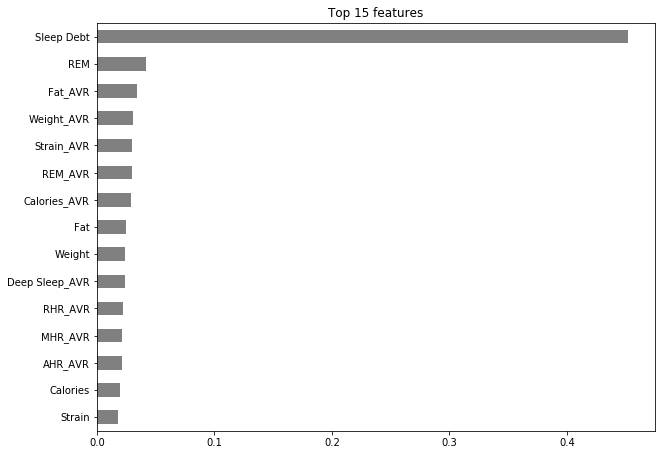

In [35]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train_encoded.columns)

n = 15
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [66]:

y_pred_proba = pipeline.predict_proba(X_val)[:, -1] # Probability for the last class
roc_auc_score(y_val, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

ValueError: ignored

###Select K best for features

In [67]:
for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_encoded, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features


TypeError: ignored

In [60]:
from IPython.display import display, HTML

# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fit Ridge Regression model
    feature = 'Sleep Debt_AVR'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_encoded[[feature]], y_train)
    
    # Get Test MAE
    y_pred = model.predict(X_test[[feature]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    train.plot.scatter(feature, target, alpha=0.05)
    plt.plot(X_test[feature], y_pred)
    plt.show()

ValueError: ignored

#Visualization Sketches


In [0]:

plt.plot(df['REM_AVR'])
plt.plot(df['Deep Sleep_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(df['REM'])
plt.plot(df['REM_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(df['Sleep Debt'])
plt.plot(df['Sleep Debt_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(df['Deep Sleep'])
plt.plot(df['Deep Sleep_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(df['Sleep Debt_AVR'],color="blue")
plt.plot(df['HRV_AVR'])
plt.plot(df['RHR_AVR'])
plt.title('Heart')
plt.xlabel('Date')
plt.ylabel('Minutes');


In [0]:
plt.plot(df['Deep Sleep_AVR'],color="red")
plt.plot(df['Sleep Debt_AVR'],color="green")
plt.plot(df['REM_AVR'],color="purple")
plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(train['Sleep Debt'])
plt.plot(train['HRV'])
plt.plot(train['RHR'])
plt.title('Heart')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(val['Sleep Debt'])
plt.plot(val['HRV'])
plt.plot(val['RHR'])
plt.title('Heart')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(df['HRV'])
plt.plot(df['Recovery'])
plt.title('Recovery')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
plt.plot(df['Strain_AVR'])
plt.plot(df['Calories_AVR'])
plt.plot(df['AHR_AVR'])
plt.plot(df['MHR_AVR'])
plt.title('Work')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [0]:
df['Strain'] = np.log(df['Strain'])

In [0]:
len(rf.feature_importances_)

In [0]:
len(X_train.columns)


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:, -1] # Probability for the last class
roc_auc_score(y_val, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})


import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');